<a href="https://colab.research.google.com/github/lo-uis/Team_ChoLab/blob/develop/stl_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-lightning

     |████████████████████████████████| 256kB 8.7MB/s 
     |████████████████████████████████| 829kB 14.7MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=b3952cdd2105e00a702914d592cfe8e55e8eeb1e913654d7679d84dec5b80eaf
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# **前処理**

In [47]:
# tranform tensor
#前処理できる
#trainデータセットの前処理


transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    #transforms.RandomResizedCrop(224), #サイズ合わせ
    #transforms.RandomHorizontalFlip(), 
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor() ,              #型変換(?)
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  #https://teratail.com/questions/234027
    
    ])

In [48]:
#validationデータセットの前処理
transform_val = transforms.Compose([
    transforms.Resize(224), #サイズ合わせ
    transforms.CenterCrop(224),
    #transforms.RandomResizedCrop(224), #サイズ合わせ
    transforms.ToTensor() ,              #型変換(?)
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225) ) #多分正規化
    ])

In [49]:
pwd

'/content/drive/My Drive'

In [50]:
cd drive

[Errno 2] No such file or directory: 'drive'
/content/drive/My Drive


In [51]:
cd My Drive

[Errno 2] No such file or directory: 'My Drive'
/content/drive/My Drive


In [52]:
from torchvision import datasets

In [53]:
train = datasets.ImageFolder(root="./data/train", transform=transform_train) 

In [54]:
val = datasets.ImageFolder(root="./data/val", transform=transform_val) 

In [55]:
#データセットの中身を確認
train

Dataset ImageFolder
    Number of datapoints: 1800
    Root location: ./data/train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [56]:
val

Dataset ImageFolder
    Number of datapoints: 600
    Root location: ./data/val
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [57]:
#train[0][0].shape

In [58]:
#可視化してみる
import numpy as np
import matplotlib.pyplot as plt
img = np.transpose(train[1][0],(1,2,0))
img.shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


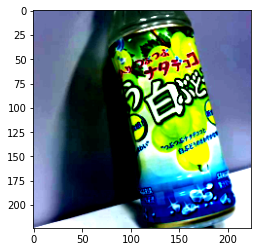

In [59]:
plt.imshow(img)

In [35]:
#type(train[0])

In [36]:
#train[0][0]

In [37]:
#train[1][1]

In [60]:
batch_size = 32

training_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False) # testはvaldationとして扱う

classes = ("jui","ocha","piza","pop","pre","toppo")

#dataloaders_dict = {"train": train_dataloader, "val": val_dataloader} # 辞書オブジェクトにまとめる

# **VGG16ファインチューニング**
参考：https://github.com/YutaroOgawa/pytorch_advanced

In [39]:
# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを生成
#GPU使う
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_pretrained = True  # 学習済みのパラメータを使用
model = models.vgg16(pretrained=use_pretrained).to(device)
print(model)


model.classifier[6] = nn.Linear(in_features=4096, out_features=10).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [40]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [41]:
# ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 再学習するパラメーターを指定する
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# パラメータごとに各リストに格納する
for name, param in model.named_parameters():
    if update_param_names_1[0] in name:
    
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3に格納：", name)

    else:
        param.requires_grad = False
        print("勾配計算なし。学習しない：", name)
  

params_to_update_1に格納： features.0.weight
params_to_update_1に格納： features.0.bias
params_to_update_1に格納： features.2.weight
params_to_update_1に格納： features.2.bias
params_to_update_1に格納： features.5.weight
params_to_update_1に格納： features.5.bias
params_to_update_1に格納： features.7.weight
params_to_update_1に格納： features.7.bias
params_to_update_1に格納： features.10.weight
params_to_update_1に格納： features.10.bias
params_to_update_1に格納： features.12.weight
params_to_update_1に格納： features.12.bias
params_to_update_1に格納： features.14.weight
params_to_update_1に格納： features.14.bias
params_to_update_1に格納： features.17.weight
params_to_update_1に格納： features.17.bias
params_to_update_1に格納： features.19.weight
params_to_update_1に格納： features.19.bias
params_to_update_1に格納： features.21.weight
params_to_update_1に格納： features.21.bias
params_to_update_1に格納： features.24.weight
params_to_update_1に格納： features.24.bias
params_to_update_1に格納： features.26.weight
params_to_update_1に格納： features.26.bias
params_to_update_1に格納： f

In [42]:

#EarlyStopipingを導入するために、pytorchtools.pyをアップする
from pytorchtools import EarlyStopping

In [43]:
# 最適化手法の設定
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-5},
    {'params': params_to_update_2, 'lr': 5e-5},
    {'params': params_to_update_3, 'lr': 1e-4}
], momentum=0.9)

In [44]:
epochs = 60
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
early_stopping = EarlyStopping(patience=3, verbose=True)  # early stopping patience; how long to wait after last time validation loss improved.

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  model.train() #学習モード
  
  for inputs, labels in tqdm(training_loader):
#     DataLoaderのバッチサイズごとにforで取り出して計算
#     ここのforの処理が終わると1エポック
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
#     一旦パラメーターの勾配をゼロにして
    optimizer.zero_grad()
#     勾配の計算
    loss.backward()
#     学習
    optimizer.step()
    
#     分類わけなので、もっとも数字が大きいものをpredictとする
#     バッチ処理しているので2次元目で比較
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
#     ラベルと合っているものを足し合わせてaccuracy計算
    running_corrects += torch.sum(preds == labels.data)
  
  model.eval() #検証モード
#     pytorchでは勾配の計算の高速化のため、パラメーターを保持しているがテスト時はいらないので止める
  with torch.no_grad():
    for val_inputs, val_labels in tqdm(validation_loader):
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)
      
      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)
      
#   学習過程を記録
  epoch_loss = running_loss/len(training_loader.dataset)
  epoch_acc = running_corrects.float()/ len(training_loader.dataset)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc)
  
  val_epoch_loss = val_running_loss/len(validation_loader.dataset)
#     print('len-validation_loader :'+str(len(validation_loader)))
#     print('len-validation_loader :'+str(len(validation_loader.dataset)))
  val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
  val_running_loss_history.append(val_epoch_loss)
  val_running_corrects_history.append(val_epoch_acc)
  
  print('epoch *', (e+1))
  print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
  print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))

  early_stopping(val_epoch_loss, model)
        
  if early_stopping.early_stop:
      print("Early stopping")
      break
#学習済みモデルの保存
save_path = './weights.pth'
torch.save(model.state_dict(), save_path)

 60%|█████▉    | 34/57 [11:10<07:30, 19.60s/it]

KeyboardInterrupt: ignored

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

In [ ]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

**混同行列**
参考：https://github.com/takoroy/mypytorch-memo

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, labels):
    import seaborn as sns
    import pandas as pd
    sns.set()
    
    df = pd.DataFrame(cm)
    df.index = labels
    df.columns = labels

    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(df, annot=True, fmt="d", linewidths=.5, ax=ax)

def validation_confusion_matrix(model):
    images_so_far = 0
    fig = plt.figure()

    all_labels = np.array([])
    all_preds = np.array([])
    for i, data in enumerate(validation_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        all_labels = np.append(all_labels, labels.cpu().data.numpy())
        all_preds = np.append(all_preds, preds.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, classes)

In [ ]:
validation_confusion_matrix(model)

# **DenseNet**

In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_pretrained = True  # 学習済みのパラメータを使用
model = models.densenet161(pretrained=use_pretrained).to(device)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth


In [62]:
model.classifier = nn.Linear(in_features=2208, out_features=6, bias=True).to(device)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [63]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [64]:
# ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する
#https://qiita.com/koshian2/items/4f91ac5cceb6125fd57e

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []
params_to_update_4 = []


# 再学習するパラメーターを指定する
update_param_names_1 = ["denseblock2"]
update_param_names_2 = ["denseblock3"]
update_param_names_3 = ["denseblock4"]
update_param_names_4 = ["classifier.weight", "classifier.bias"]

# パラメータごとに各リストに格納する
for name, param in model.named_parameters():
    if update_param_names_1[0] in name:
    
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納：", name)

    elif update_param_names_2[0] in name:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)
    
    elif update_param_names_3[0] in name:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)

    elif name in update_param_names_4:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3に格納：", name)

    else:
        param.requires_grad = False
        print("勾配計算なし。学習しない：", name)
  

勾配計算なし。学習しない： features.conv0.weight
勾配計算なし。学習しない： features.norm0.weight
勾配計算なし。学習しない： features.norm0.bias
勾配計算なし。学習しない： features.denseblock1.denselayer1.norm1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer1.norm1.bias
勾配計算なし。学習しない： features.denseblock1.denselayer1.conv1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer1.norm2.weight
勾配計算なし。学習しない： features.denseblock1.denselayer1.norm2.bias
勾配計算なし。学習しない： features.denseblock1.denselayer1.conv2.weight
勾配計算なし。学習しない： features.denseblock1.denselayer2.norm1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer2.norm1.bias
勾配計算なし。学習しない： features.denseblock1.denselayer2.conv1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer2.norm2.weight
勾配計算なし。学習しない： features.denseblock1.denselayer2.norm2.bias
勾配計算なし。学習しない： features.denseblock1.denselayer2.conv2.weight
勾配計算なし。学習しない： features.denseblock1.denselayer3.norm1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer3.norm1.bias
勾配計算なし。学習しない： features.denseblock1.denselayer3.conv1.weight
勾配計算

In [65]:
#EarlyStopipingを導入するために、pytorchtools.pyをアップする
from pytorchtools import EarlyStopping

In [66]:
# 最適化手法の設定
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 1e-4},
    {'params': params_to_update_3, 'lr': 1e-4},
    {'params': params_to_update_4, 'lr': 1e-3}
], momentum=0.9)

In [67]:
epochs = 150
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
early_stopping = EarlyStopping(patience=3, verbose=True)  # early stopping patience; how long to wait after last time validation loss improved.

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  model.train() #学習モード
  
  for inputs, labels in tqdm(training_loader):
#     DataLoaderのバッチサイズごとにforで取り出して計算
#     ここのforの処理が終わると1エポック
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
#     一旦パラメーターの勾配をゼロにして
    optimizer.zero_grad()
#     勾配の計算
    loss.backward()
#     学習
    optimizer.step()
    
#     分類わけなので、もっとも数字が大きいものをpredictとする
#     バッチ処理しているので2次元目で比較
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
#     ラベルと合っているものを足し合わせてaccuracy計算
    running_corrects += torch.sum(preds == labels.data)
  
  model.eval() #検証モード
#     pytorchでは勾配の計算の高速化のため、パラメーターを保持しているがテスト時はいらないので止める
  with torch.no_grad():
    for val_inputs, val_labels in tqdm(validation_loader):
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)
      
      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)
      
#   学習過程を記録
  epoch_loss = running_loss/len(training_loader.dataset)
  epoch_acc = running_corrects.float()/ len(training_loader.dataset)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc)
  
  val_epoch_loss = val_running_loss/len(validation_loader.dataset)
#     print('len-validation_loader :'+str(len(validation_loader)))
#     print('len-validation_loader :'+str(len(validation_loader.dataset)))
  val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
  val_running_loss_history.append(val_epoch_loss)
  val_running_corrects_history.append(val_epoch_acc)
  
  print('epoch *', (e+1))
  print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
  print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))

  early_stopping(val_epoch_loss, model)
        
  if early_stopping.early_stop:
      print("Early stopping")
      break
#学習済みモデルの保存
#save_path = './weights.pth'
#torch.save(model.state_dict(), save_path)


100%|██████████| 57/57 [08:10<00:00,  8.60s/it]

100%|██████████| 19/19 [06:02<00:00, 19.10s/it]


epoch * 1
training loss: 0.0372, training acc 0.8000
validation loss: 0.0284, validation acc0.9800
Validation loss decreased (inf --> 0.028387).  Saving model ...



100%|██████████| 57/57 [01:06<00:00,  1.16s/it]

100%|██████████| 19/19 [00:13<00:00,  1.36it/s]


epoch * 2
training loss: 0.0126, training acc 1.0000
validation loss: 0.0171, validation acc0.9983
Validation loss decreased (0.028387 --> 0.017115).  Saving model ...



100%|██████████| 57/57 [01:06<00:00,  1.16s/it]

100%|██████████| 19/19 [00:13<00:00,  1.36it/s]


epoch * 3
training loss: 0.0060, training acc 1.0000
validation loss: 0.0117, validation acc1.0000
Validation loss decreased (0.017115 --> 0.011654).  Saving model ...



100%|██████████| 57/57 [01:06<00:00,  1.16s/it]

100%|██████████| 19/19 [00:13<00:00,  1.37it/s]


epoch * 4
training loss: 0.0038, training acc 1.0000
validation loss: 0.0085, validation acc1.0000
Validation loss decreased (0.011654 --> 0.008482).  Saving model ...



100%|██████████| 57/57 [01:06<00:00,  1.16s/it]

100%|██████████| 19/19 [00:14<00:00,  1.34it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

epoch * 5
training loss: 0.0029, training acc 1.0000
validation loss: 0.0086, validation acc1.0000
EarlyStopping counter: 1 out of 3



100%|██████████| 57/57 [01:06<00:00,  1.16s/it]

100%|██████████| 19/19 [00:13<00:00,  1.37it/s]


epoch * 6
training loss: 0.0022, training acc 1.0000
validation loss: 0.0068, validation acc1.0000
Validation loss decreased (0.008482 --> 0.006788).  Saving model ...



100%|██████████| 57/57 [01:06<00:00,  1.16s/it]

100%|██████████| 19/19 [00:13<00:00,  1.38it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

epoch * 7
training loss: 0.0018, training acc 1.0000
validation loss: 0.0072, validation acc1.0000
EarlyStopping counter: 1 out of 3



100%|██████████| 57/57 [01:06<00:00,  1.16s/it]

100%|██████████| 19/19 [00:13<00:00,  1.37it/s]


epoch * 8
training loss: 0.0015, training acc 1.0000
validation loss: 0.0050, validation acc1.0000
Validation loss decreased (0.006788 --> 0.004992).  Saving model ...



100%|██████████| 57/57 [01:05<00:00,  1.16s/it]

100%|██████████| 19/19 [00:13<00:00,  1.38it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

epoch * 9
training loss: 0.0012, training acc 1.0000
validation loss: 0.0053, validation acc1.0000
EarlyStopping counter: 1 out of 3



100%|██████████| 57/57 [01:05<00:00,  1.15s/it]

100%|██████████| 19/19 [00:13<00:00,  1.37it/s]


epoch * 10
training loss: 0.0011, training acc 1.0000
validation loss: 0.0048, validation acc1.0000
Validation loss decreased (0.004992 --> 0.004755).  Saving model ...



100%|██████████| 57/57 [01:05<00:00,  1.15s/it]

100%|██████████| 19/19 [00:13<00:00,  1.38it/s]


epoch * 11
training loss: 0.0010, training acc 1.0000
validation loss: 0.0046, validation acc1.0000
Validation loss decreased (0.004755 --> 0.004618).  Saving model ...



100%|██████████| 57/57 [01:05<00:00,  1.16s/it]

100%|██████████| 19/19 [00:13<00:00,  1.38it/s]


epoch * 12
training loss: 0.0009, training acc 1.0000
validation loss: 0.0036, validation acc1.0000
Validation loss decreased (0.004618 --> 0.003625).  Saving model ...



100%|██████████| 57/57 [01:06<00:00,  1.16s/it]

100%|██████████| 19/19 [00:13<00:00,  1.38it/s]


epoch * 13
training loss: 0.0008, training acc 1.0000
validation loss: 0.0036, validation acc1.0000
Validation loss decreased (0.003625 --> 0.003594).  Saving model ...



100%|██████████| 57/57 [01:05<00:00,  1.16s/it]

100%|██████████| 19/19 [00:13<00:00,  1.37it/s]


epoch * 14
training loss: 0.0008, training acc 1.0000
validation loss: 0.0029, validation acc1.0000
Validation loss decreased (0.003594 --> 0.002867).  Saving model ...



100%|██████████| 57/57 [01:05<00:00,  1.15s/it]

100%|██████████| 19/19 [00:13<00:00,  1.37it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

epoch * 15
training loss: 0.0006, training acc 1.0000
validation loss: 0.0036, validation acc1.0000
EarlyStopping counter: 1 out of 3



100%|██████████| 57/57 [01:05<00:00,  1.16s/it]

100%|██████████| 19/19 [00:13<00:00,  1.38it/s]


epoch * 16
training loss: 0.0007, training acc 1.0000
validation loss: 0.0026, validation acc1.0000
Validation loss decreased (0.002867 --> 0.002602).  Saving model ...



100%|██████████| 57/57 [01:06<00:00,  1.16s/it]

100%|██████████| 19/19 [00:13<00:00,  1.37it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

epoch * 17
training loss: 0.0006, training acc 1.0000
validation loss: 0.0035, validation acc1.0000
EarlyStopping counter: 1 out of 3



100%|██████████| 57/57 [01:05<00:00,  1.15s/it]

100%|██████████| 19/19 [00:13<00:00,  1.37it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

epoch * 18
training loss: 0.0006, training acc 1.0000
validation loss: 0.0030, validation acc1.0000
EarlyStopping counter: 2 out of 3



100%|██████████| 57/57 [01:05<00:00,  1.15s/it]

100%|██████████| 19/19 [00:13<00:00,  1.38it/s]

epoch * 19
training loss: 0.0005, training acc 1.0000
validation loss: 0.0026, validation acc1.0000
EarlyStopping counter: 3 out of 3
Early stopping


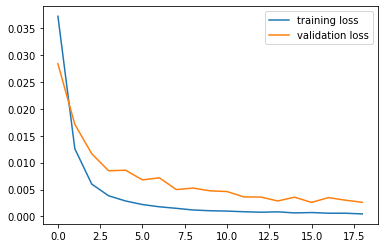

In [68]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

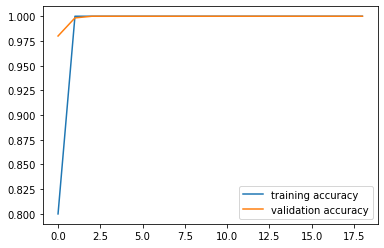

In [69]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [70]:
#学習済みモデルの保存
save_path = './weights.pth'
torch.save(model.state_dict(), save_path)